In [2]:
import numpy as np
from matplotlib import pyplot as plt
import cvxopt

The general convex optimization problem is:
\begin{equation}
\begin{aligned}
\text{minimize } & \frac{1}{2} \mathbf{x}^T \mathbf{P} \mathbf{x} + \mathbf{q}^T\mathbf{x} \\
\text{subject to } & \mathbf{G}\mathbf{x} \leq \mathbf{h} \\
& \mathbf{A}\mathbf{x} = \mathbf{b}.
\end{aligned}
\end{equation}

In the general (soft or hard margin) SVDD formulation, the equations given in Tax, 2004 are as follows:
\begin{equation}
\begin{aligned}
\max_\mathbf{a} \text{ } & \mathcal{L}(\mathbf{a}) = \sum_{n=1}^{N}a_n k(\mathbf{x}_n, \mathbf{x}_n) -\sum_{n=1}^{N}\sum_{m=1}^N a_n a_m k(\mathbf{x}_n, \mathbf{x}_m), \\
&\text{such that } 0 \leq a_n \leq C \\
& \text{and } \sum_{n=1}^N a_i = 1  \\
\end{aligned}
\end{equation}

There is also a formulation for SVDD that includes negative samples. The derivation is slightly more involved, but at the end of the derivation it is revealed that if one defines a variable $a^{'}_i$ as $a^{'}_i = y_i a_i$, we can simply reformulate the problem as 
\begin{equation}
\begin{aligned}
\max_\mathbf{a}^{'} \text{ } & \mathcal{L}(\mathbf{a}^{'}) = \sum_{n=1}^{N}a^{'}_n k(\mathbf{x}_n, \mathbf{x}_n) -\sum_{n=1}^{N}\sum_{m=1}^N a^{'}_n a^{'}_m k(\mathbf{x}_n, \mathbf{x}_m), \\
&\text{such that } 0 \leq a^{'}_n \leq C \\
& \text{and } \sum_{n=1}^N a^{'}_i = 1  \\
\end{aligned}
\end{equation}

Note that the variable $y_i \in \{-1, 1\}$, and $y_i=-1$ is given to samples that the radius should not encompass. Finally, we can calculate the centroid $\alpha$ using
\begin{equation}
\boldsymbol\alpha = \sum a^{'}_i \mathbf{x_i}.
\end{equation}

If we test new data, we can do so using the radius formula
\begin{equation}
R^2 = k(\mathbf{x}_k, \mathbf{x}_k) - 2 \sum_i a^{'}_i k(\mathbf{x}_i, \mathbf{x}_k) + \sum_{i}\sum_{j} k(\mathbf{x}_i, \mathbf{x}_j)
\end{equation}

where $\mathbf{x}_k$ is any support vector. This radius is used to test new data using:
\begin{equation}
\Vert \mathbf{z} - \boldsymbol\alpha \Vert_2^2 = k(\mathbf{z}, \mathbf{z}) - 2 \sum_i a^{'}_i k(\mathbf{z}, \mathbf{x}_k) + \sum_{i}\sum_{j} k(\mathbf{x}_i, \mathbf{x}_j) \leq R^2
\end{equation}

we can subtract $R^2 - \Vert \mathbf{z} - \boldsymbol\alpha \Vert_2^2$ to produce a positive value if a test sample is in the decision boundary, or a negative value otherwise.

We can immediately see that we can rewrite this to be suitable to the convex optimisation problem: let us reformulate the convex problem with $\mathbf{x} = \mathbf{a}$ to give the following matrices (let $\otimes$ be the outer product):

\begin{equation}
\mathbf{P} = 2 * \mathbf{t}\otimes \mathbf{t} * \mathbf{K}(X),
\end{equation}
where $\mathbf{K}$ is the gram matrix:
\begin{equation}
K_{ij} = k(\mathbf{x}_i, \mathbf{x}_j),
\end{equation}

Furthermore, $\mathbf{q}$ is simply:
\begin{equation}
\mathbf{q} = -\mathbf{t} * \text{diag}(\mathbf{K}).T.
\end{equation}

If we solve to hard margin problem ($C = \infty$, $a_n \geq 0$), then $\mathbf{G}$ is simply the negative diagonal matrix with $\mathbf{t}$ on the diagonal.
\begin{equation}
\mathbf{G}_{hard} = - \text{diag}(\mathbf{t})
\end{equation}
and $\mathbf{h}$ is simply a zero vector
\begin{equation}
\mathbf{h} = \mathbf{0}.
\end{equation}

However, if we solve to soft margin problem ($0\leq a_n \leq C$), $\mathbf{G}$ and $\mathbf{h}$ become
\begin{equation}
\mathbf{G}_{soft} = [\mathbf{G_1}, \mathbf{G_2}]^T
\end{equation}
\begin{equation}
\mathbf{G_1} = -\text{diag}(\mathbf{t})
\end{equation}
\begin{equation}
\mathbf{G_2} = \text{diag}(\mathbf{t})
\end{equation}
\begin{equation}
\mathbf{h} = [\mathbf{h}_1, \mathbf{h}_2]^T
\end{equation}
\begin{equation}
\mathbf{h}_1 = \mathbf{0}
\end{equation}
\begin{equation}
\mathbf{h}_2 = C * \mathbf{1}
\end{equation}

Finally, the final equality constraint is simple, as both $\mathbf{A} = \mathbf{1}$, where $\mathbf{A}$ is the one vector and $\mathbf{b} = 1$.

We can also demonstrate how the convex problem is formulated for $a^{'}_i = y_i a_i$: let us reformulate the convex problem with $\mathbf{x} = \mathbf{a}$ to give the following matrices (let $\otimes$ be the outer product):

\begin{equation}
\mathbf{P} = 2 * \mathbf{K}(X),
\end{equation}
where $\mathbf{K}$ is the gram matrix:
\begin{equation}
K_{ij} = k(\mathbf{x}_i, \mathbf{x}_j),
\end{equation}

Furthermore, $\mathbf{q}$ is simply:
\begin{equation}
\mathbf{q} = -\text{diag}(\mathbf{K}).
\end{equation}

If we solve to hard margin problem ($C = \infty$, $a_n \geq 0$), then $\mathbf{G}$ is simply the negative identify matrix.
\begin{equation}
\mathbf{G}_{hard} = - \mathbf{I}
\end{equation}
and $\mathbf{h}$ is simply a zero vector
\begin{equation}
\mathbf{h} = \mathbf{0}.
\end{equation}

However, if we solve to soft margin problem ($0\leq a_n \leq C$), $\mathbf{G}$ and $\mathbf{h}$ become
\begin{equation}
\mathbf{G}_{soft} = [\mathbf{G_1}, \mathbf{G_2}]^T
\end{equation}
\begin{equation}
\mathbf{G_1} = -\mathbf{I}
\end{equation}
\begin{equation}
\mathbf{G_2} = \mathbf{I}
\end{equation}
\begin{equation}
\mathbf{h} = [\mathbf{h}_1, \mathbf{h}_2]^T
\end{equation}
\begin{equation}
\mathbf{h}_1 = \mathbf{0}
\end{equation}
\begin{equation}
\mathbf{h}_2 = C * \mathbf{1}
\end{equation}

Finally, the final equality constraint is simple, as both $\mathbf{A} = \mathbf{1}$, where $\mathbf{A}$ is the one vector and $\mathbf{b} = 1$.

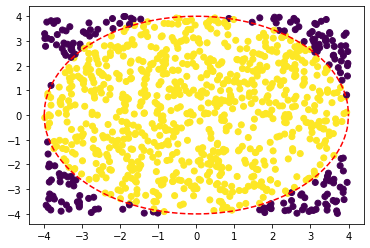

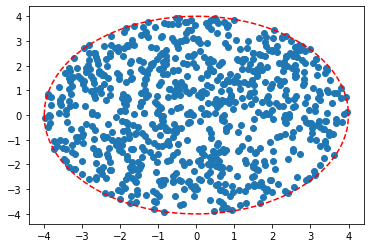

In [3]:
N_sample = 1000
R = 4
x_data = np.random.random(N_sample) * 8 - 4
y_data = np.random.random(N_sample) * 8 - 4

X_data = np.vstack((x_data, y_data)).T

R_data = np.sum(X_data**2, axis = 1)

labels = 2 * (R_data < R**2) - 1

x_plot = np.linspace(-4, 4, 400)

plt.figure()
plt.scatter(X_data[:, 0], X_data[:, 1], c = labels)
plt.plot(x_plot, np.sqrt(16 - x_plot**2), "r--")
plt.plot(x_plot, -np.sqrt(16 - x_plot**2), "r--")
plt.show()

#Get data only in sphere
X = X_data[np.nonzero(R_data < R**2)[0], :]

plt.figure()
plt.scatter(X[:, 0], X[:, 1])
plt.plot(x_plot, np.sqrt(16 - x_plot**2), "r--")
plt.plot(x_plot, -np.sqrt(16 - x_plot**2), "r--")
plt.show()

In [18]:
class SVDD(object):
    def __init__(self, kernel = 'linear', degree = 3, gamma = 1, C = None, alpha_threshold = 1e-5):
        
        self.kernel = kernel
        self.degree = degree #polynomial kernel degree
        self.gamma = gamma #Gaussian kernel 1/variance
        self.C = C
        self.alpha_threshold = alpha_threshold

    def linear_kernel(self, x1, x2):
        return np.dot(x1, x2)
    
    def polynomial_kernel(self, x1, x2):
        return (1 + np.dot(x1, x2)) **self.degree
    
    def gaussian_kernel(self, x1, x2):
        return np.exp(-1 * self.gamma * (np.linalg.norm(x1 - x2)**2))
    
    def apply_kernel_function(self, x1, x2):
        
        if self.kernel == 'linear':
            return self.linear_kernel(x1, x2)
        
        elif self.kernel == 'polynomial':
            return self.polynomial_kernel(x1, x2)
            
        elif self.kernel == 'gaussian':
            return self.gaussian_kernel(x1, x2)
        
        else:
            print("Illegal kernel function chosen.")
            raise SystemExit
    
    def calculate_gram(self, X):
        n, f = X.shape
        
        K = np.zeros((n, n))
        
        for i in range(n):
            for j in range(n):
                K[i, j] = self.apply_kernel_function(X[i, :], X[j, :])
        
        return K
    
    def fit(self, X, y = None):
        
        #labels can be None, but 
        n = X.shape[0]
        
        if y is None:
            y = np.ones(n)
            
        else:
            assert len(y) == n
        
        #Determine gram matrix
        Gram = self.calculate_gram(X)
        
        #Setup necessary matrices to be used for lagrangian multipliers
        #P and q
        
        P = cvxopt.matrix(2 * np.outer(y, y) *  Gram)
        q = cvxopt.matrix(-1 * y.reshape(-1, 1) * np.diag(Gram).reshape(-1, 1))
        
        #G and h
        if self.C is None:
            print("\nSolving the hard margin problem!")
            G = cvxopt.matrix(-1 * np.diag(y))
            h = cvxopt.matrix(np.zeros((n, 1)))
            
        else:
            print("\nSolving the soft margin problem!")
            G_1 = -1 * np.diag(y)
            h_1 = np.zeros((n, 1))
            
            G_2 = np.diag(y)
            h_2 = self.C * np.ones((n, 1))
            
            G = cvxopt.matrix(np.vstack((G_1, G_2)))
            h = cvxopt.matrix(np.vstack((h_1, h_2)))
        
        #A and b
        A = cvxopt.matrix(y.reshape(1, -1))
        b = cvxopt.matrix(np.ones((1, 1)))
        
        #We are now ready to solve the convex optimisation problem!
        self.solution = cvxopt.solvers.qp(P, q, G, h, A, b)  
        print(self.solution)
        
        #Save alphas
        self.alphas = np.array(self.solution['x'])[:, 0]
        
        #Setup index lists!
        support_alpha_indices = []
        
        for cnt, i in enumerate(self.alphas):
            if i >= self.alpha_threshold:
                if self.C is not None:
                     if i != self.C:
                        support_alpha_indices.append(cnt)
                        
                else:
                    support_alpha_indices.append(cnt)
                        
        
        self.support_alpha_indices = support_alpha_indices
        self.support_alphas = self.alphas[self.support_alpha_indices]
        self.support_vectors = X[self.support_alpha_indices, :]
        self.support_labels = y[self.support_alpha_indices]
        self.sv_weights = self.support_alphas * self.support_labels #alpha_prime for sv's
        
        #Calculate center
        self.center = np.sum(self.sv_weights.reshape(-1, 1) * self.support_vectors, axis = 0)
        
        #Calculate radius
        sv_index = 0 #Use first support vector to compute radius
        actual_index = self.support_alpha_indices[sv_index]
        
        #Compute sv_gram (will simply model evaluation and prediction)
        self.Gram_svs = self.calculate_gram(self.support_vectors)
        
        t1 = Gram[actual_index, actual_index]
        t2 = -2 * np.dot(self.sv_weights, self.Gram_svs[sv_index, :])
        t3 = np.dot(self.sv_weights.reshape(-1, 1).T, np.dot(self.Gram_svs, self.sv_weights.reshape(-1, 1)))
        
        self.square_radius = t1 + t2 + t3
    
    def evaluate_model(self, x):
        #X = (N,) array
        
        pred_val = 0
        
        t1_pred = self.apply_kernel_function(x, x)
        
        t2_pred = 0
        
        for cnt, i in enumerate(self.sv_weights):
            t2_pred += i * self.apply_kernel_function(x, self.support_vectors[cnt, :])
        
        t2_pred *= -2
        
        t3_pred = np.dot(self.sv_weights.reshape(-1, 1).T, np.dot(self.Gram_svs, self.sv_weights.reshape(-1, 1)))
        
        return t1_pred + t2_pred + t3_pred
    
    def predict(self, X):

        if len(X.shape) > 1:

            n = X.shape[0]
            prediction = np.zeros(n)

            for i in range(n):
                prediction[i] = self.square_radius - self.evaluate_model(X[i, :])

        else:
            prediction = self.square_radius - self.evaluate_model(X)

        return prediction



If we test new data, we can do so using the radius formula
\begin{equation}
R^2 = k(\mathbf{x}_k, \mathbf{x}_k) - 2 \sum_i a^{'}_i k(\mathbf{x}_i, \mathbf{x}_k) + \sum_{i}\sum_{j} k(\mathbf{x}_i, \mathbf{x}_j)
\end{equation}

where $\mathbf{x}_k$ is any support vector. This radius is used to test new data using:
\begin{equation}
\Vert \mathbf{z} - \boldsymbol\alpha \Vert_2^2 = k(\mathbf{z}, \mathbf{z}) - 2 \sum_i a^{'}_i k(\mathbf{z}, \mathbf{x}_k) + \sum_{i}\sum_{j} k(\mathbf{x}_i, \mathbf{x}_j) \leq R^2
\end{equation}

we can subtract $R^2 - \Vert \mathbf{z} - \boldsymbol\alpha \Vert_2^2$ to produce a positive value if a test sample is in the decision boundary, or a negative value otherwise.


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.6613e+03 -3.9415e+03  4e+04  7e+00  5e-14
 1: -1.5487e+03 -2.7491e+03  5e+03  6e-01  4e-14
 2: -4.8825e+02 -8.4099e+02  1e+03  2e-01  2e-14
 3: -9.3662e+01 -2.7888e+02  4e+02  4e-02  1e-14
 4: -1.4200e+01 -3.1081e+01  2e+01  1e-03  4e-15
 5: -1.4010e+01 -1.9645e+01  6e+00  2e-04  2e-15
 6: -1.4023e+01 -1.9638e+01  6e+00  1e-04  2e-15
 7: -1.4329e+01 -1.9024e+01  5e+00  1e-04  1e-15
 8: -1.5661e+01 -1.6463e+01  8e-01  9e-16  2e-15
 9: -1.5939e+01 -1.6043e+01  1e-01  5e-16  2e-15
10: -1.5983e+01 -1.5986e+01  3e-03  2e-16  2e-15
11: -1.5984e+01 -1.5984e+01  3e-05  7e-16  2e-15
12: -1.5984e+01 -1.5984e+01  3e-07  4e-15  2e-15
Optimal solution found.
{'x': <796x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <1592x1 matrix, tc='d'>, 'z': <1592x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.8977411976525387e-07, 'relative gap': 1.8128603073867783e-08, 'primal objective': -15.98436010676193, 'dual ob

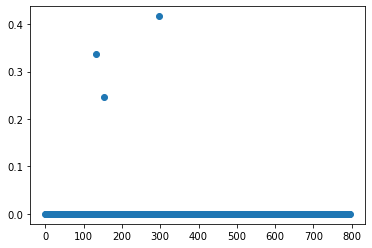

[0.00017067 0.00180894] [[15.98435835]]


In [19]:
svdd_test = SVDD('linear', C = 1)
svdd_test.fit(X)

plt.figure()
plt.scatter(np.arange(len(svdd_test.alphas)), svdd_test.alphas)
plt.show()

print(svdd_test.center, svdd_test.square_radius)

In [22]:
query = np.array([3.5, 0])
svdd_test.predict(query)

2


array([[3.73554975]])

10000
796


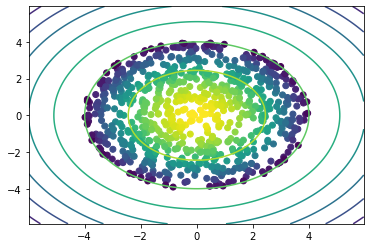

796


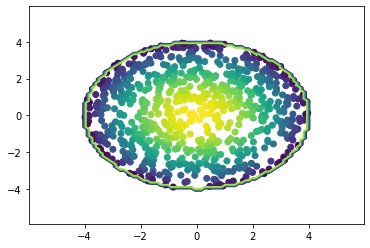

In [25]:
N_grid = 100
X_m, Y_m = np.meshgrid(np.linspace(np.min(X[:, 0]) - 2, np.max(X[:, 0]) + 2, N_grid), np.linspace(np.min(X[:, 1]) - 2, np.max(X[:, 1]) + 2, N_grid))

X_grid = np.hstack((X_m.reshape(-1, 1), Y_m.reshape(-1, 1)))

Z = svdd_test.predict(X_grid)

plt.figure()
plt.contour(X_m, Y_m, Z.reshape(N_grid, N_grid))
plt.scatter(X[:, 0], X[:, 1], c = svdd_test.predict(X))
plt.show()

plt.figure()
plt.contour(X_m, Y_m, np.sign(Z.reshape(N_grid, N_grid)))
plt.scatter(X[:, 0], X[:, 1], c = svdd_test.predict(X))
plt.show()

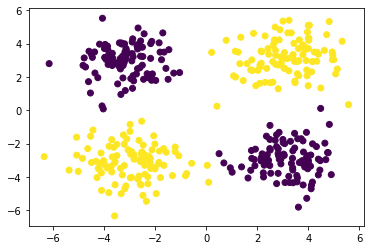

In [42]:
X1 = np.random.randn(100, 2) + np.array([3, 3])
X2 = np.random.randn(100, 2) + np.array([-3, -3])
X3 = np.random.randn(100, 2) + np.array([-3, 3])
X4 = np.random.randn(100, 2) + np.array([3, -3])

l1 = np.ones(100)
l2 = np.ones(100)
X = np.vstack((X1, X2, X3, X4))
labels = np.hstack((l1, l2, -l1, -l2))


plt.figure()
plt.scatter(X[:, 0], X[:, 1], c = labels)
plt.show()



Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.7312e-01 -4.0224e+03  9e+03  1e-01  8e-15
 1: -9.6164e-01 -8.1186e+01  1e+02  1e-03  2e-15
 2: -9.5356e-01 -8.3959e+00  8e+00  1e-05  3e-15
 3: -9.5389e-01 -1.1210e+00  2e-01  3e-07  3e-15
 4: -9.6318e-01 -1.0324e+00  7e-02  9e-08  1e-15
 5: -9.7265e-01 -9.9960e-01  3e-02  3e-16  4e-16
 6: -9.7436e-01 -9.8082e-01  6e-03  2e-16  4e-16
 7: -9.7480e-01 -9.7626e-01  1e-03  4e-16  4e-16
 8: -9.7493e-01 -9.7529e-01  4e-04  4e-16  4e-16
 9: -9.7498e-01 -9.7507e-01  9e-05  2e-16  4e-16
10: -9.7500e-01 -9.7503e-01  3e-05  3e-16  4e-16
11: -9.7500e-01 -9.7501e-01  8e-06  3e-16  4e-16
12: -9.7501e-01 -9.7501e-01  1e-06  3e-16  4e-16
13: -9.7501e-01 -9.7501e-01  2e-07  2e-16  4e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.3182351677190276e-07, 'relative gap': 2.377662119040814e-07, 'p

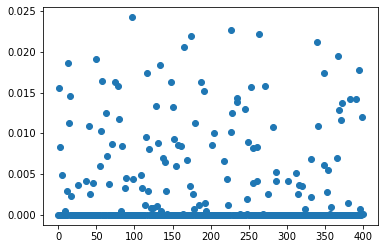

In [49]:
svdd_test = SVDD('gaussian', C = 10, gamma = 1)
svdd_test.fit(X, labels)

plt.figure()
plt.scatter(np.arange(len(svdd_test.alphas)), svdd_test.alphas * labels)
plt.show()

10000
400


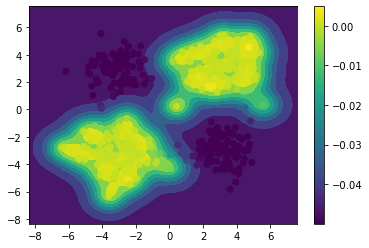

400


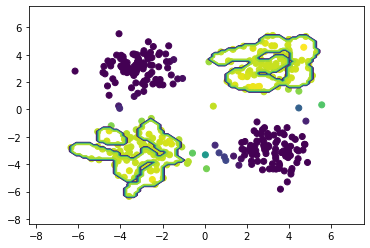

In [50]:
N_grid = 100
X_m, Y_m = np.meshgrid(np.linspace(np.min(X[:, 0]) - 2, np.max(X[:, 0]) + 2, N_grid), np.linspace(np.min(X[:, 1]) - 2, np.max(X[:, 1]) + 2, N_grid))

X_grid = np.hstack((X_m.reshape(-1, 1), Y_m.reshape(-1, 1)))

Z = svdd_test.predict(X_grid)

plt.figure()
plt.contourf(X_m, Y_m, Z.reshape(N_grid, N_grid))
plt.scatter(X[:, 0], X[:, 1], c = svdd_test.predict(X))
plt.colorbar()
plt.show()

plt.figure()
plt.contour(X_m, Y_m, np.sign(Z.reshape(N_grid, N_grid)))
plt.scatter(X[:, 0], X[:, 1], c = svdd_test.predict(X))
plt.show()